# Convolutional Variational Autoencoder for Handwritten Digit 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it. 

## Buyang Li, Yuxuan Li

In [2]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

In [3]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows, img_cols, 1) 
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows, img_cols, 1) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255. 
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 28, 28, 1)
60000 train samples, 10000 test samples


## The model

In [4]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2
strides = 2
padding = 'same'

### Fill in this block to build the encoder model

In [15]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [16]:
# use reparameterization trick to push the sampling out as input instead of sampling from Q(z|X)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps
       
    Arguments:
        args:       mean and log of variance of Q(z|X)

    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    
    return mean + K.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [17]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_4[0][0]']               
                                                                                            

In [18]:
shape=[1,14,14,16]
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

x = layers.Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           strides=2,
                           padding='same')(x)

outputs = layers.Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 16)                48        
                                                                 
 dense_12 (Dense)            (None, 3136)              53312     
                                                                 
 reshape_4 (Reshape)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       4640      
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                     

In [19]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols
kl_loss =  -0.5 *K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.RMSprop(0.0005, decay=1e-6)
vae.compile(optimizer=optimizer)

In [20]:
BATCH = 100
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
600/600 [==============================] - 33s 53ms/step - loss: 205.1183 - val_loss: 177.2614
Epoch 2/40
600/600 [==============================] - 34s 56ms/step - loss: 173.0013 - val_loss: 169.6240
Epoch 3/40
600/600 [==============================] - 33s 54ms/step - loss: 167.4726 - val_loss: 165.2288
Epoch 4/40
600/600 [==============================] - 32s 53ms/step - loss: 164.0319 - val_loss: 163.3049
Epoch 5/40
600/600 [==============================] - 32s 53ms/step - loss: 161.5516 - val_loss: 160.5865
Epoch 6/40
600/600 [==============================] - 33s 54ms/step - loss: 159.7727 - val_loss: 159.0986
Epoch 7/40
600/600 [==============================] - 31s 52ms/step - loss: 158.4186 - val_loss: 158.4868
Epoch 8/40
600/600 [==============================] - 33s 55ms/step - loss: 157.4605 - val_loss: 157.8529
Epoch 9/40
600/600 [==============================] - 32s 53ms/step - loss: 156.7159 - val_loss: 157.3875
Epoch 10/40
600/600 [=========================

In [37]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 15x15 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(15, 15))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

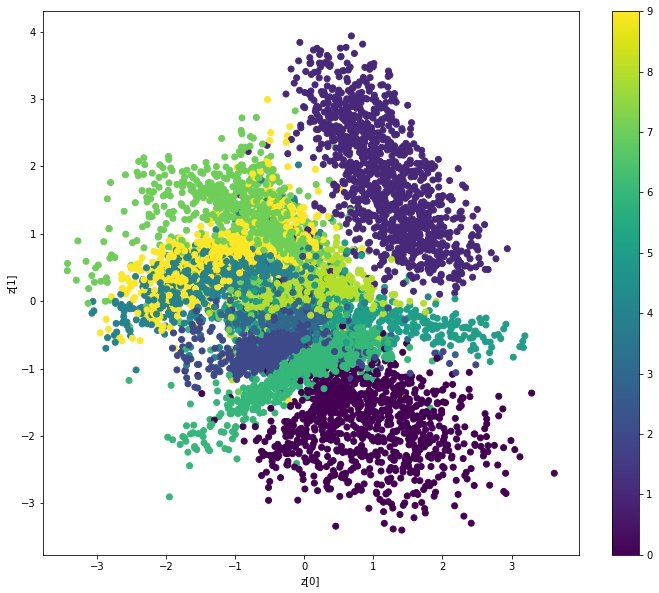

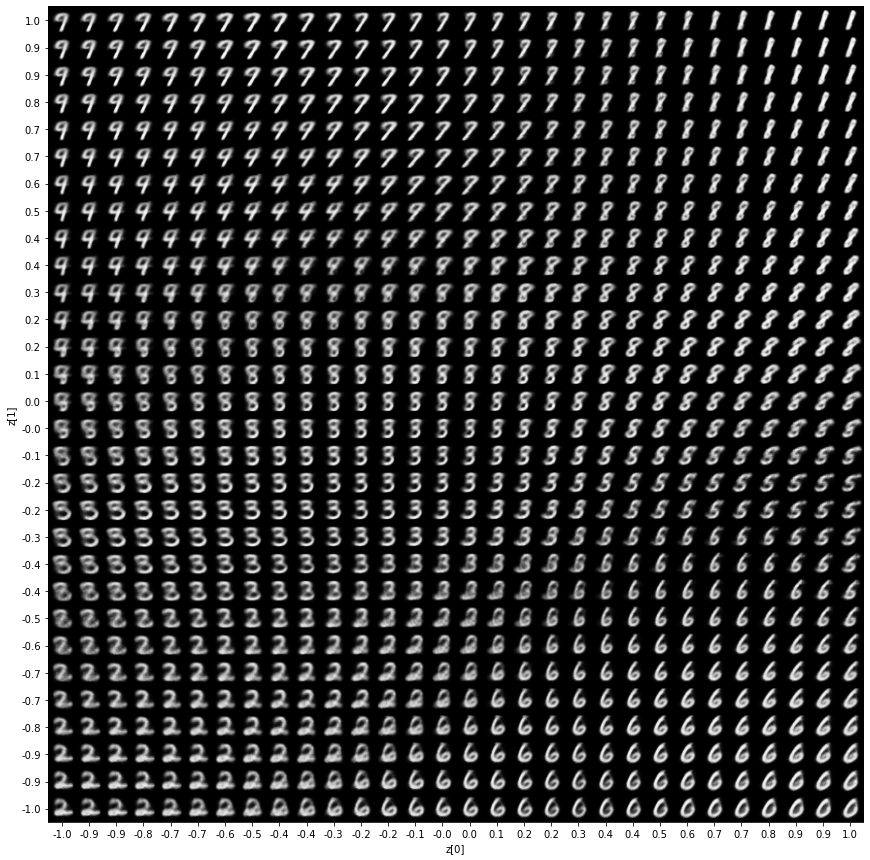

In [38]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_cnn")